## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Summary](#summary)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. It is important to have some experience working with the difficulties of these. 

In this project, the results of an A/B test run by an e-commerce company have been analyzed in order to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

Import the libraries:

In [65]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

<a id='probability'></a>
### Part I - Probability

1. Understanding the dataset.

a. Read in the ab_data.csv data.

In [66]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [67]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [68]:
df['user_id'].nunique()

290584

d. Do any of the rows have missing values?

In [69]:
df.isna().any(axis=1).sum()

0

e. The proportion of users converted.

In [70]:
len(df[df['converted'] == 1]) / len(df['converted'])

0.11965919355605512

f. The number of times the **new page** and treatment don't line up.

In [71]:
len(df.query('group == "treatment" and landing_page != "new_page"')) + len(df.query('group == "control" and landing_page != "old_page"'))

3893

2. Messy data

a. Drop rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**.

In [72]:
df2 = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
         ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Double check all of the incorrect rows were removed.

In [73]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

3. Updated dataframe.

a. The number of unique **user_id**s.

In [74]:
df2['user_id'].nunique()

290584

b. Repeated **user_id** in **df2**.

In [75]:
df2['user_id'][df2['user_id'].duplicated()].values[0]

773192

c. Row information for the repeat **user_id**.

In [76]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove one of the rows with a duplicate **user_id**.

In [77]:
df2 = df2.drop_duplicates('user_id', keep='first')

e. Double check the duplicate row was removed.

In [78]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


4. Probability

a. Probability of an individual converting regardless of the page.

In [79]:
len(df2[df2['converted'] == 1]) / len(df2['converted'])

0.11959708724499628

b. Probability of an individual converting given that it was in the **control** group

In [80]:
p_old = len(df2[(df2['group'] == 'control') & (df2['converted'] == 1)]) / len(df2[df2['group'] == 'control'])
p_old

0.1203863045004612

c. Probability of an individual converting given that it was in the **treatment** group

In [81]:
p_new = len(df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)]) / len(df2[df2['group'] == 'treatment'])
p_new

0.11880806551510564

d. Probability that an individual received the new page.

In [82]:
len(df2[df2['landing_page'] == 'new_page']) / len(df2)

0.5000619442226688

**Conclusion:**

- Given only the probabilities from *a.* to *d.*, there is **not sufficient evidence** to say that the new landing page (conversion rate 0.1188) leads to more conversions than the old landing page (conversion rate 0.1204).

<a id='ab_test'></a>
### Part II - A/B Test


If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses are as follows:

**$H_{0}$: $p_{old}$ - $p_{new}$ $\geq$ 0**,<br> i.e. the new landing page has a conversion rate **greater than or equal to** the old landing page.

**$H_{1}$: $p_{old}$ - $p_{new}$ < 0**,<br> i.e. the new landing page has a conversion rate **less than** the old landing page.<br>

Right now, we assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

**$H_{0}$: $p_{old}$ - $p_{new}$ = 0**,<br> i.e. the conversion rate of the new landing page is **equal** to the conversion rate of the old landing page.

**$H_{1}$: $p_{old}$ - $p_{new}$ $\neq$ 0**,<br> i.e. the conversion rate of the new landing page is **not equal** to the conversion rate of the old landing page.



a. **Convert rate** for $p_{new}$ under the null.

In [83]:
# Under the null, there is no difference in conversion based on the page
p = len(df2[df2['converted'] == 1]) / len(df2)
p

0.11959708724499628

b. **Convert rate** for $p_{old}$ under the null.

In [84]:
# Under the null, there is no difference in conversion based on the page
p = len(df2[df2['converted'] == 1]) / len(df2)
p

0.11959708724499628

c. $n_{new}$

In [85]:
n_new = len(df2[df2['group'] == 'treatment'])
n_new

145310

d. $n_{old}$

In [86]:
n_old = len(df2[df2['group'] == 'control'])
n_old

145274

e. Now, we simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [87]:
new_page_converted = []
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p, p])

f. Similarly, we simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [88]:
old_page_converted = []
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p, p])

g. $p_{new}$ - $p_{old}$ for the simulated values.

In [89]:
new_page_converted.mean() - old_page_converted.mean()

-0.00019487682651572746

h. Now, we simulate 10,000 $p_{new}$ - $p_{old}$ values similar to the process used in parts a. through g. above and store these 10,000 values in a numpy array called **p_diffs**. The mean of this value is calle the **mean of the sampling distribution**.

In [90]:
# Simulate p_new - p_old for 10,000 iterations
p_diffs, old_page_converted, new_page_converted = [], [], []

for _ in range(10000):
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p, p]).mean()
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p, p]).mean()
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.array(p_diffs)

i. Histogram of **p_diffs**. This looks normally distributed due to the **law of large numbers** and the **central limit theorem**.

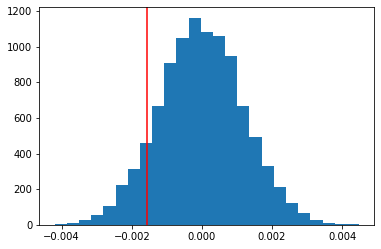

In [91]:
plt.hist(p_diffs, bins=25);
plt.axvline((p_new-p_old), color='red'); # mean difference in conversion rate


j. The p-value of the distribution is the proportion of the **p_diffs** that is greater than the actual difference in **ab_data.csv**.

In [92]:
(p_diffs > (p_new - p_old)).mean()

0.9034

k. Compute the test statistic and the p-value using stats.proportions_ztest. See the [Docs]('https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html') for more information.

In [93]:
convert_old = len(df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)])
convert_new = len(df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)])

n_old = len(df2[df2['group'] == 'control'])
n_new = len(df2[df2['group'] == 'treatment'])

In [94]:
import statsmodels as sm

stat, pval = sm.stats.proportion.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

print('Z-score:', stat)
print('P-value:', pval)

Z-score: -1.3109241984234394
P-value: 0.9050583127590245


**Conclusion:**

- The consistent p-value of ~0.9 suggests that $H_{0}$ is true. If the p-value was less than or equal to 0.5, then we could reject the $H_{0}$ and suggest that there is a statistically significant difference.
- There is **no statistically significant difference** between the new and the old page.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we achieved in the previous A/B test can also be achieved by performing regression. The regression output gives us an information whether or not the features are statistically significant for predicting the target value. Since each row is binary (either a conversion or no conversion), we perform a **logistic regression** in this case. <br><br>

a. Create a column for the intercept, and create a dummy variable column for which page each user received (1 when an individual receives the **treatment** and 0 if **control**).

In [95]:
# Add intercept
# This is necessary when performing logistic regression with categorical features
df2['intercept'] = 1

# Add column ab_page
ab_page = pd.get_dummies(df['group'])
ab_page.rename(columns={'treatment':'ab_page'}, inplace=True)
ab_page.drop(['control'], axis=1, inplace=True)
df2 = df2.join(ab_page)

b. We use **statsmodels** to perform logistic regression to see if there is a significant difference in conversion based on which page a customer receives.

In [96]:
import statsmodels.api as sm

model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Summary of the logistic regression model.

In [97]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:24:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**Conclusion:**

- Based on the p-value associated with **ab_page** of 0.190, we fail to reject the null hypothesis again. This indicates that the landing page is **not statistically significant** for predicting the conversion rate. 

Note: The p-values in **Part II** (~0.9) and in **Part III** (0.190) differ because both p-values are related to different hypotheses. The p-value in **Part II** addresses whether or not there is a statistically significant difference in the conversion rates. The p-value in **Part III** addresses whether or not the landing page is statistically significant.

d. Now, we are considering other things that might influence whether or not an individual converts. This is necessary, because there must be other information that have an impact on whether or not a user converts.

Examples:
- the time spent on the website,
- the weekday,
- the time,
- the location of the user,
- the hardware and the browser used.

For example, if the weekday had a statistically significant positive effect on the conversion rate, then the new page may be shown only on weekdays with a significant difference between both landing_pages.

e. Now along with testing if the conversion rate changes for different pages, we add an effect based on which country a user lives which is captured in **countries.csv** 

In [98]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

f. Though we have looked at the individual factors of country and page on conversion earlier, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [99]:
# Create interaction features
countries = pd.get_dummies(df_new['country'])
df_new = df_new.join(countries)

df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_page_CA,ab_page_UK,ab_page_US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


g. Fit the logistic regression and obtain the results. The feature **ab_page_US** serves as a baseline to avoid multicollinearity.

In [100]:
model2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page_CA', 'ab_page_UK']])
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:               2.364e-05
Time:                        18:24:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
ab_page_CA    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
ab_page_UK     0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

**Conclusion:**

Note: The feature **ab_page_US** served as a baseline for the logistic regression.

- The p-value of 0.389 for **ab_page_UK** means that the feature is **not statistically significant** for predicting the **conversion rate**.
- The p-value of 0.046 for **ab_page_CA** means that the feature is **statistically significant** for predicting the **conversion rate**.
- The **ab_page_CA** coefficient of -0.0752 can be interpreted as follows: If a user in Canada gets to see the new page, it is 1/e^(-0.0752) = 1.078 times **less likely** to be converted than if a user in the US (baseline) gets to see the new page, holding all other variables constant.

<a id='summary'></a>
### Summary

- Both page and country does not have a consistent statistical significance to predict the conversion of a user.
- Based on these results, the e-commerce company should not implement the new website.